In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tabpfn_extensions import TabPFNRegressor,interpretability

# Import tabpfn adapters from interpretability module
from tabpfn_extensions.interpretability import shapiq as tabpfn_shapiq


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/欧洲柴油单一利润拟合残差_10ppm.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['欧洲柴油单一利润拟合残差/新加坡10ppm柴油裂解'].last_valid_index()
 
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,欧洲柴油单一利润拟合残差/新加坡10ppm柴油裂解,Brent-Dubai/7DMA,欧洲融资需求同差,欧元区经济惊喜指数,全球经济惊喜指数（同花顺）超季节性/3年,LME铜价同比,德国-美国10年期国债收益率,欧洲ARA地区柴油库存超季节性/3年,欧元兑美元,西北欧轻质原油进口量/中重质原油进口量/4WMA
2025-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent-Dubai_合并数据.xlsx"),    
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent-Dubai_合并数据.xlsx")
]

file_path1 = None
for path1 in file_paths1:
    if os.path.isfile(path1):  # 确保是文件而不是目录
        file_path1 = path1
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path1, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")
sheet1.tail()

,Date,预测值
4,2025-08-18,0.6
3,2025-08-19,0.6
2,2025-08-20,0.6
1,2025-08-21,0.6
0,2025-08-22,0.6


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/铜/eta/LME铜价_合并数据.xlsx"),    
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/铜/eta/LME铜价_合并数据.xlsx")
]

file_path2 = None
for path2 in file_paths2:
    if os.path.isfile(path2):  # 确保是文件而不是目录
        file_path2 = path2
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.read_excel(file_path2, sheet_name='Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['真实值'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
    sheet2.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")
sheet2.tail()

,Date,预测值
4,2025-08-05,9405.9
3,2025-08-06,9405.9
2,2025-08-07,9405.9
1,2025-08-08,9405.9
0,2025-08-11,9406.7


In [7]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']].assign(预测值=lambda x: x['预测值'].rolling(7).mean()),
    on='Date',
    how='left'
)
sheet_daily['Brent-Dubai/7DMA'] = sheet_daily['Brent-Dubai/7DMA'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['LME铜价同比'] = sheet_daily['LME铜价同比'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [8]:
sheet.columns

Index(['欧洲柴油单一利润拟合残差/新加坡10ppm柴油裂解', 'Brent-Dubai/7DMA', '欧洲融资需求同差',
       '欧元区经济惊喜指数', '全球经济惊喜指数（同花顺）超季节性/3年', 'LME铜价同比', '德国-美国10年期国债收益率',
       '欧洲ARA地区柴油库存超季节性/3年', '欧元兑美元', '西北欧轻质原油进口量/中重质原油进口量/4WMA'],
      dtype='object')

In [9]:
################################# 处理缺失值 #################################
fill_methods = {
'Brent-Dubai/7DMA': 'interpolate', 
'欧洲融资需求同差': 'interpolate',
'欧元区经济惊喜指数': 'interpolate', 
'全球经济惊喜指数（同花顺）超季节性/3年': 'interpolate', 
'LME铜价同比': 'interpolate', 
'德国-美国10年期国债收益率': 'interpolate'  ,
'欧洲ARA地区柴油库存超季节性/3年': 'interpolate', 
'欧元兑美元': 'interpolate', 
'西北欧轻质原油进口量/中重质原油进口量/4WMA': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'] = sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'].interpolate(method='linear')

#################################  因子处理  #################################
sheet['欧洲融资需求同差_提前20天'] = sheet['欧洲融资需求同差'].shift(20)
sheet['欧元区经济惊喜指数_提前10天'] = sheet['欧元区经济惊喜指数'].shift(10)
sheet['全球经济惊喜指数（同花顺）超季节性/3年_提前20天'] = sheet['全球经济惊喜指数（同花顺）超季节性/3年'].shift(20)
sheet['德国-美国10年期国债收益率_提前40天'] = sheet['德国-美国10年期国债收益率'].shift(40)
sheet['欧洲ARA地区柴油库存超季节性/3年_提前20天'] = sheet['欧洲ARA地区柴油库存超季节性/3年'].shift(20)
sheet['欧元兑美元_提前90天'] = sheet['欧元兑美元'].shift(90)
sheet['西北欧轻质原油进口量/中重质原油进口量/4WMA_提前10天'] = sheet['西北欧轻质原油进口量/中重质原油进口量/4WMA'].shift(10)



sheet['Brent-Dubai/7DMA_逆序'] = reverse_column(sheet, 'Brent-Dubai/7DMA')
sheet['德国-美国10年期国债收益率_提前40天_逆序'] = reverse_column(sheet, '德国-美国10年期国债收益率_提前40天')
sheet['欧洲ARA地区柴油库存超季节性/3年_提前20天_逆序'] = reverse_column(sheet, '欧洲ARA地区柴油库存超季节性/3年_提前20天')


'''
# 获取最后20个数据点
last_20_points = sheet.tail(20)

# 处理每一列
for col in ['乙烯下游加权开工率/周度超季节性/3年_提前10天']:
    # 找出重复值
    duplicates = last_20_points[col][last_20_points[col].duplicated(keep='first')]
    # 如果重复值超过3个,保留第一个出现的值,其他置为空
    if len(duplicates) >= 3:
        sheet.loc[sheet.index[-20:], col] = sheet.loc[sheet.index[-20:], col].mask(
            lambda x: x.duplicated(keep='first')
        )

sheet[['乙烯下游加权开工率/周度超季节性/3年_提前10天']]

'''
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['欧洲柴油单一利润拟合残差/新加坡10ppm柴油裂解'].notna())
]

################################# 数据 读取-处理 结束 #################################

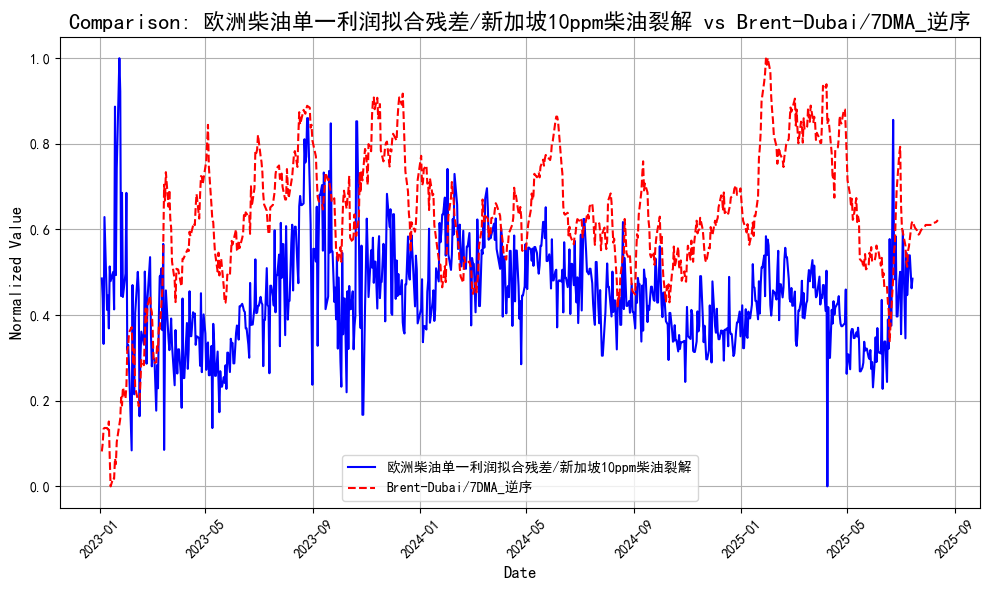

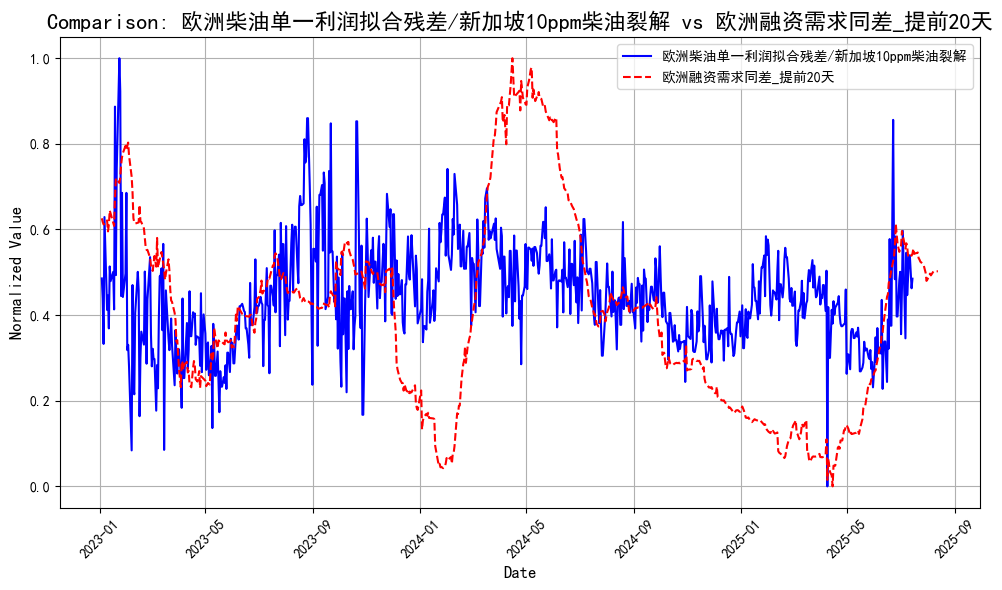

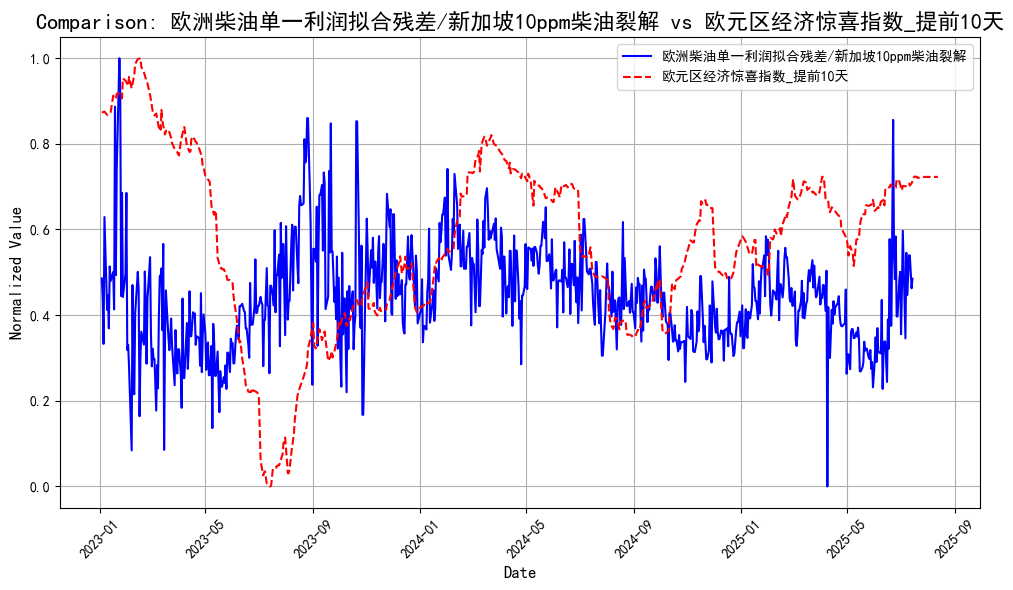

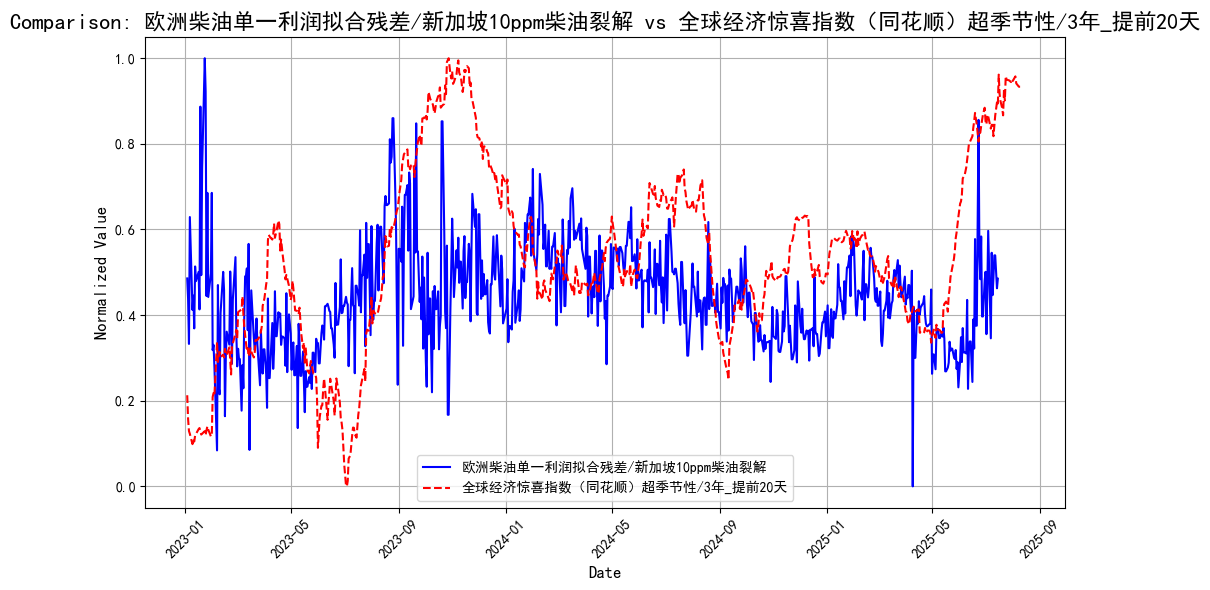

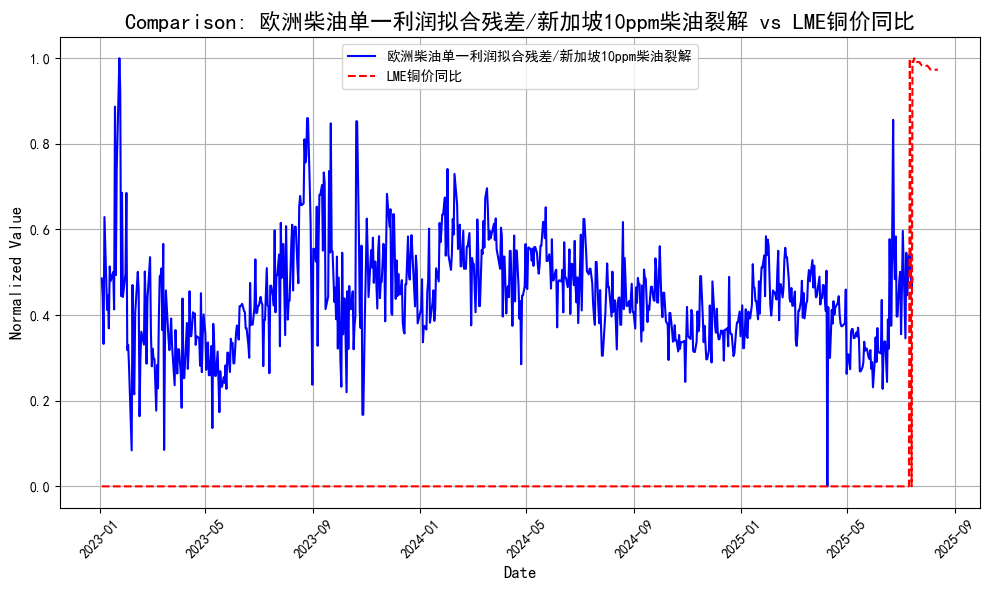

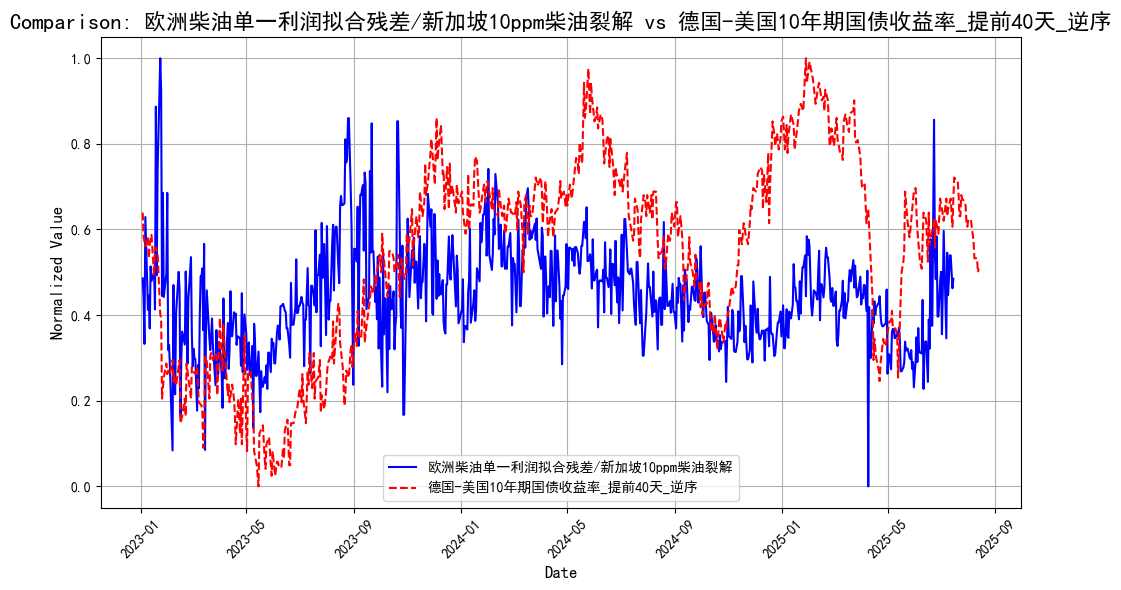

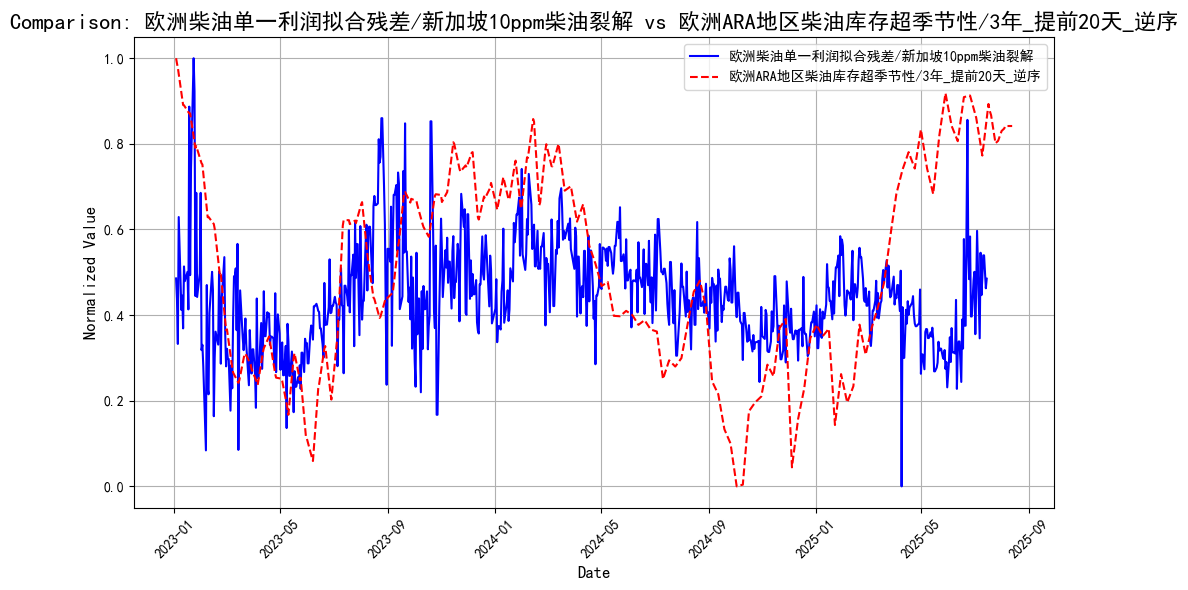

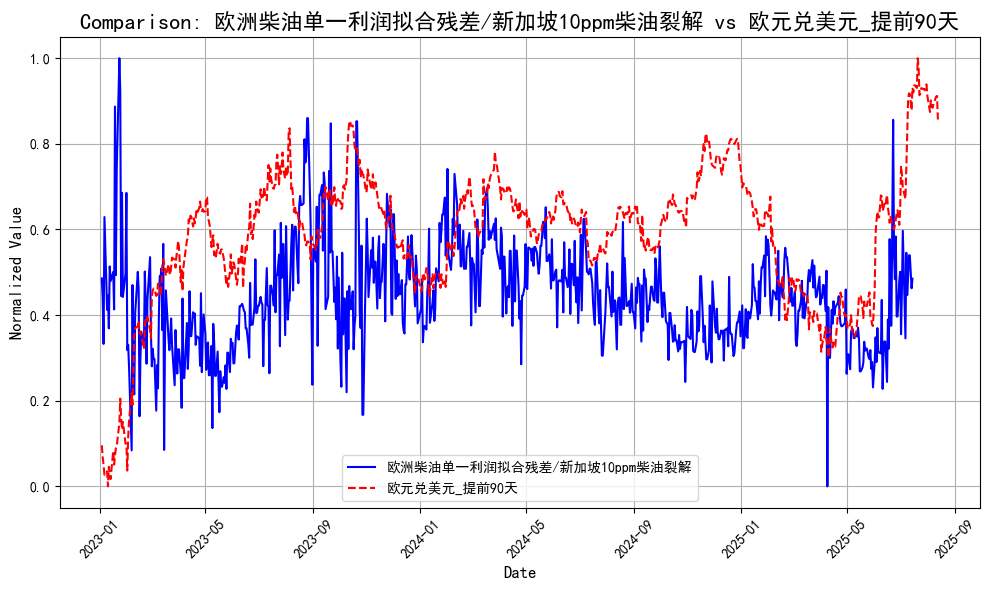

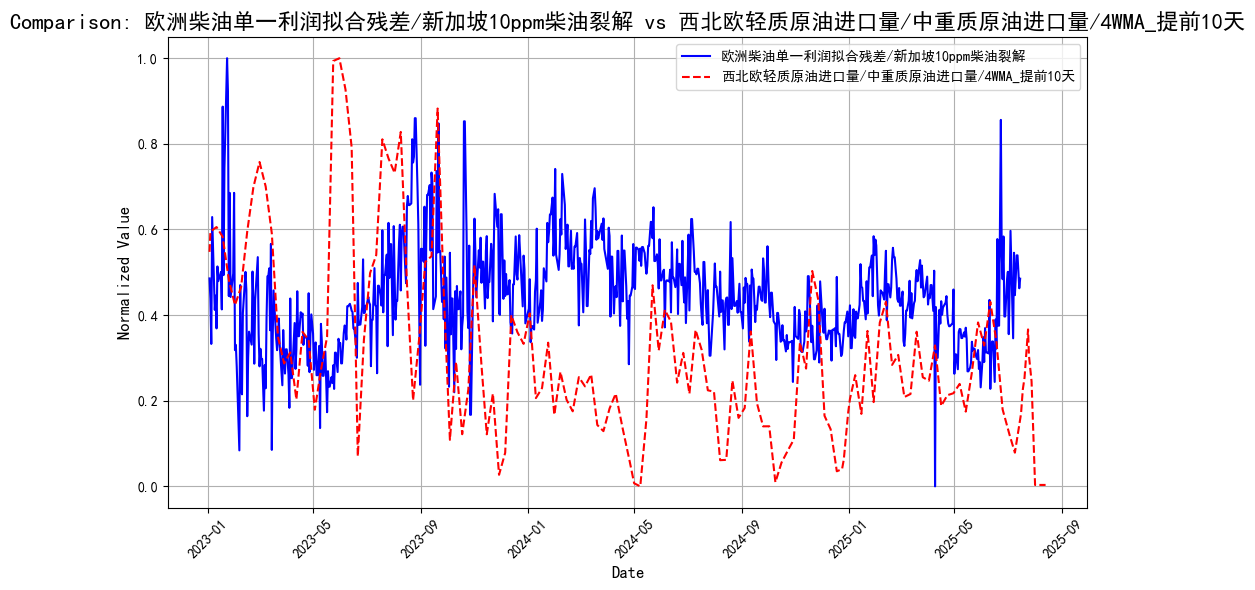

In [10]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='欧洲柴油单一利润拟合残差/新加坡10ppm柴油裂解', 
    compare_cols=[
        'Brent-Dubai/7DMA_逆序',
        '欧洲融资需求同差_提前20天',
        '欧元区经济惊喜指数_提前10天',
        '全球经济惊喜指数（同花顺）超季节性/3年_提前20天',
        'LME铜价同比',
        '德国-美国10年期国债收益率_提前40天_逆序',
        '欧洲ARA地区柴油库存超季节性/3年_提前20天_逆序',
        '欧元兑美元_提前90天',
        '西北欧轻质原油进口量/中重质原油进口量/4WMA_提前10天'
        ]
)

In [11]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'Brent-Dubai/7DMA_逆序',
        '欧洲融资需求同差_提前20天',
        '欧元区经济惊喜指数_提前10天',
        '全球经济惊喜指数（同花顺）超季节性/3年_提前20天',
        'LME铜价同比',
        '德国-美国10年期国债收益率_提前40天_逆序',
        '欧洲ARA地区柴油库存超季节性/3年_提前20天_逆序',
        '欧元兑美元_提前90天',
        '西北欧轻质原油进口量/中重质原油进口量/4WMA_提前10天'
]

predict_column = '欧洲柴油单一利润拟合残差/新加坡10ppm柴油裂解'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]


In [12]:

################################# TabPFN 模型 训练 测试 预测 #################################

# 初始化回归器
regressor = TabPFNRegressor()
regressor.fit(X_train, y_train)

# 在测试集和未来数据上预测
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE (TabPFN): {round(train_mse, 4)}, 训练集 R² (TabPFN): {round(train_r2, 4)}")
print(f"测试集 MSE (TabPFN): {round(test_mse, 4)}, 测试集 R² (TabPFN): {round(test_r2, 4)}")

# 存储预测结果
y_future_pred = regressor.predict(X_future)
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred


c:\Users\hzins\anaconda3\Lib\site-packages\tabpfn\regressor.py:460: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


训练集 MSE (TabPFN): 0.6695, 训练集 R² (TabPFN): 0.7374
测试集 MSE (TabPFN): 2.9828, 测试集 R² (TabPFN): -0.4428


In [13]:

################################# TabPFN 模型 训练 测试 预测 所有数据 #################################
# 合并所有数据
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 初始化回归器
regressor_all = TabPFNRegressor()
regressor_all.fit(X_all, y_all)

# 预测所有数据和未来数据
y_all_pred = regressor_all.predict(X_all)
y_future_pred_all = regressor_all.predict(X_future)

# 评估模型
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

c:\Users\hzins\anaconda3\Lib\site-packages\tabpfn\regressor.py:460: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


全部数据 MSE: 0.6964, 全部数据 R²: 0.7268


In [14]:
'''
# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=regressor_all,
    X=X_all,
    y=y_all,
    n_features_to_select=5,  # How many features to select
    feature_names=X_all.columns,
)

# Print selected features
selected_features = [
    X_all.columns[i] for i in range(len(X_all.columns)) if sfs.get_support()[i]
]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")
'''

'\n# Feature selection\nsfs = interpretability.feature_selection.feature_selection(\n    estimator=regressor_all,\n    X=X_all,\n    y=y_all,\n    n_features_to_select=5,  # How many features to select\n    feature_names=X_all.columns,\n)\n\n# Print selected features\nselected_features = [\n    X_all.columns[i] for i in range(len(X_all.columns)) if sfs.get_support()[i]\n]\nprint("\nSelected features:")\nfor feature in selected_features:\n    print(f"- {feature}")\n'

In [15]:
'''
# Get a TabPFNExplainer
n_model_evals = 500
x_explain = X_all.iloc[0].to_numpy() # 转换为numpy数组
explainer = tabpfn_shapiq.get_tabpfn_explainer(
    model=regressor_all,
    data=X_all,
    labels=X_all, 
    index="SV",  # SV: Shapley Value (like in shap)
    verbose=True,  # show a progress bar during explanation
)

# Get shap values
print("计算SHAP值...")
shapley_values = explainer.explain(x=x_explain, budget=n_model_evals)

# plot the force plot
shapley_values.plot_force(feature_names=X_all.columns)
'''

'\n# Get a TabPFNExplainer\nn_model_evals = 500\nx_explain = X_all.iloc[0].to_numpy() # 转换为numpy数组\nexplainer = tabpfn_shapiq.get_tabpfn_explainer(\n    model=regressor_all,\n    data=X_all,\n    labels=X_all, \n    index="SV",  # SV: Shapley Value (like in shap)\n    verbose=True,  # show a progress bar during explanation\n)\n\n# Get shap values\nprint("计算SHAP值...")\nshapley_values = explainer.explain(x=x_explain, budget=n_model_evals)\n\n# plot the force plot\nshapley_values.plot_force(feature_names=X_all.columns)\n'

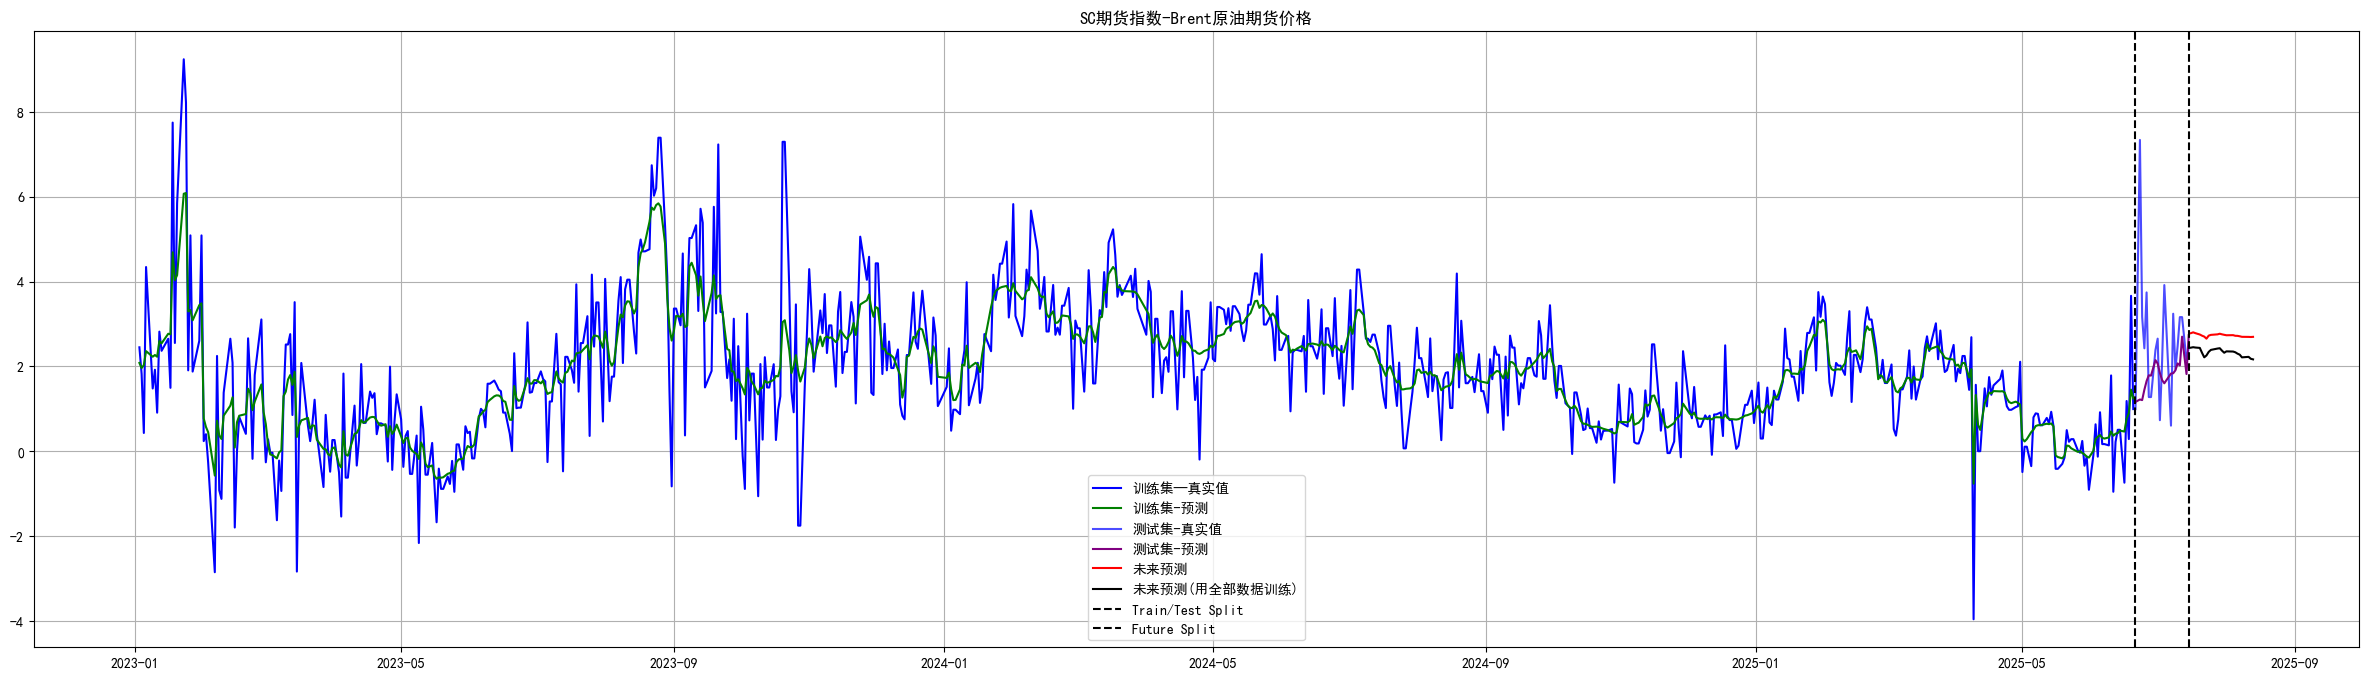

In [17]:
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') 
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('SC期货指数-Brent原油期货价格')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/欧洲柴油单一利润拟合残差_10ppm.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
783,2025/08/13,NaN,2.053167
782,2025/08/12,NaN,2.133852
781,2025/08/11,NaN,2.196161
780,2025/08/08,NaN,2.180161
779,2025/08/07,NaN,2.317014
...,...,...,...
4,2023/01/09,1.4793,NaN
3,2023/01/06,4.3414,NaN
2,2023/01/05,0.4309,NaN
1,2023/01/04,1.8206,NaN


In [21]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2024]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    #'预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
# 只保留2024年10月1日之后的预测值
merged_df_monthly.loc[merged_df_monthly.index < pd.Timestamp('2024-10-01'), '预测值'] = None

merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/欧洲柴油单一利润拟合残差_10ppm_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
19,2025/08/31,NaN,2.237392
18,2025/07/31,2.382233,1.831298
17,2025/06/30,1.274660,1.149093
16,2025/05/31,0.185985,0.381095
15,2025/04/30,1.240140,1.254518
14,2025/03/31,1.877384,1.942012
13,2025/02/28,2.250275,2.199776
12,2025/01/31,1.909504,1.900450
11,2024/12/31,0.828020,0.902517
10,2024/11/30,0.884608,0.900236


In [22]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "欧洲柴油单一利润拟合残差/新加坡10ppm柴油裂解"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [23]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "欧洲柴油单一利润拟合残差/新加坡10ppm柴油裂解"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/07/31)
数据已成功更新到Excel文件


In [24]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'SC期货指数-Brent原油期货价格',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'SC期货指数-Brent原油期货价格\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'